# Cortical geometry correlations of qMRI gradients

### Libraries

In [3]:
import os
import numpy as np
import nibabel as nb
import pandas as pd
import glob
import matplotlib.pyplot as plt
from nilearn import plotting
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainspace.datasets import load_mask
from brainspace.utils.parcellation import map_to_labels
from brainspace.datasets import load_parcellation
from brainspace.null_models import SpinPermutations
from brainstat.datasets import fetch_mask
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM
import scipy.stats as stats
from scipy import stats
import scipy as sp
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import copy
import cmocean
import statsmodels.api as sm
import pandas as pd
from sklearn.linear_model import LinearRegression
from igraph import Graph
from neuromaps.datasets import fetch_fslr
from surfplot import Plot

### Load surfaces and masks

In [4]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Path to MICAPIPE surf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

# Boolean mask
mask_surf = mask_5k != 0

f5k_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
f5k_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')

### Functions

## F1: Surface-based intensity smoothing and processing for qMRI data

In [5]:
# Function: Smooth intensity profiles on a given surface
def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=3, Relax=0.35):
    '''
    Smooths intensity data on a given surface mesh using iterative smoothing.
    
    Parameters:
    -----------
    surf_l : np.array
        Left hemisphere surface connectivity.
    surf_r : np.array
        Right hemisphere surface connectivity.
    points : np.array
        Intensity profile data mapped to the surface.
    Mask : np.array
        Binary mask indicating valid regions for smoothing.
    Kernel : str, optional
        Smoothing kernel type, options: {'uniform', 'gaussian', 'inverse_distance'}.
    Niter : int, optional
        Number of smoothing iterations (default: 3).
    Relax : float, optional
        Relaxation factor controlling smoothing intensity (default: 0.35).
    
    Returns:
    --------
    sdata : np.array
        Smoothed intensity data.
    '''
    Ndim = Mask.shape[0] 
    n2dim = int(Ndim/2)
    Mask_l = Mask[:n2dim]
    Mask_r = Mask[n2dim:]
    
    sdata = np.concatenate((
        smooth_array(surf_l, points[:n2dim], kernel=Kernel, n_iter=Niter, relax=Relax, mask=Mask_l), 
        smooth_array(surf_r, points[n2dim:], kernel=Kernel, n_iter=Niter, relax=Relax, mask=Mask_r)
    ), axis=0)
    
    return sdata

# Function: Apply smoothing to intensity profiles across all depths
def smooth_intensities(int_profile):
    '''
    Applies surface smoothing to each depth of the intensity profile.
    
    Parameters:
    -----------
    int_profile : np.array
        Input intensity profiles, where rows represent different depths.
    
    Returns:
    --------
    smoothed_i : np.array
        Smoothed intensity profiles.
    '''
    smoothed_i = np.copy(int_profile)
    
    for i in range(int_profile.shape[0]):
        smoothed_i[i, :] = smooth_surf(
            inf_lh, inf_rh, int_profile[i, :], mask_surf, Niter=5, Relax=0.5, Kernel='uniform'
        )
    
    return smoothed_i

## F2: MPC calculation

In [6]:
# Function to build the MPC from an intencity profile
def build_mpc(data, mask):
    # If no parcellation is provided, MPC will be computed vertexwise
    I = data

    # Calculate mean across columns, excluding mask and any excluded labels input
    I_M = np.nanmean(np.float32(np.where(mask, I, np.nan)), axis=1)

    # Get residuals of all columns (controlling for mean)
    I_resid = np.zeros(I.shape)
    for c in range(I.shape[1]):
        y = I[:,c]
        x = I_M
        slope, intercept, _, _, _ = sp.stats.linregress(x,y)
        y_pred = intercept + slope*x
        I_resid[:,c] = y - y_pred

    # Calculate correlation coefficient of the intesities with residuals
    R = np.corrcoef(I_resid, rowvar=False)

    # Log transform
    MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
    MPC[np.isnan(MPC)] = 0
    MPC[np.isinf(MPC)] = 0

    # CLEANUP: correct diagonal and round values to reduce file size
    # Replace all values in diagonal by zeros to account for floating point error
    for i in range(0,MPC.shape[0]):
            MPC[i,i] = 0
    
    # Output MPC, microstructural profiles, and problem nodes
    return (MPC)

# Create the gradients from the MPC matrix
def mpc_dm(MPC, mpc_mask, Ngrad=3, kernel=None, sparsity=0.9):
    # Cleanup before diffusion embeding
    MPC[~np.isfinite(MPC)] = 0
    MPC[np.isnan(MPC)] = 0
    MPC[MPC==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mpc_mask==1)[0]

    # Slice the matrix
    MPC_masked = MPC[indx, :]
    MPC_masked = MPC_masked[:, indx]
    MPC_masked.shape

    # Calculate the gradients
    MPCgm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel=kernel)
    MPCgm.fit(MPC_masked, sparsity=sparsity)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(MPCgm.gradients_.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g

        # fill in the calculated values into the corresponding indices of the new array
        grad[i] = g_nan
    
    return (MPCgm, grad)

def _build_kernel(x, kernel, gamma=None):

    if kernel in {'pearson', 'spearman'}:
        if kernel == 'spearman':
            x = np.apply_along_axis(rankdata, 1, x)
        return np.corrcoef(x)

    if kernel in {'cosine', 'normalized_angle'}:
        x = 1 - squareform(pdist(x, metric='cosine'))
        if kernel == 'normalized_angle':
            x = 1 - np.arccos(x, x)/np.pi
        return x

    if kernel == 'gaussian':
        if gamma is None:
            gamma = 1 / x.shape[1]
        return rbf_kernel(x, gamma=gamma)

    if callable(kernel):
        return kernel(x)

    raise ValueError("Unknown kernel '{0}'.".format(kernel))

def compute_affinity(x, kernel=None, sparsity=.9, pre_sparsify=True,
                     non_negative=True, gamma=None):
    """Compute affinity matrix.

    Parameters
    ----------
    x : ndarray, shape = (n_samples, n_feat)
        Input matrix.
    kernel : str, None or callable, optional
        Kernel function. If None, only sparsify. Default is None.
        Valid options:

        - If 'pearson', use Pearson's correlation coefficient.
        - If 'spearman', use Spearman's rank correlation coefficient.
        - If 'cosine', use cosine similarity.
        - If 'normalized_angle': use normalized angle between two vectors. This
          option is based on cosine similarity but provides similarities
          bounded between 0 and 1.
        - If 'gaussian', use Gaussian kernel or RBF.

    sparsity : float or None, optional
        Proportion of smallest elements to zero-out for each row.
        If None, do not sparsify. Default is 0.9.
    pre_sparsify : bool, optional
        Sparsify prior to building the affinity. If False, sparsify the final
        affinity matrix.
    non_negative : bool, optional
        If True, zero-out negative values. Otherwise, do nothing.
    gamma : float or None, optional
        Inverse kernel width. Only used if ``kernel == 'gaussian'``.
        If None, ``gamma = 1./n_feat``. Default is None.

    Returns
    -------
    affinity : ndarray, shape = (n_samples, n_samples)
        Affinity matrix.
    """

    # Do not accept sparse matrices for now
    if sp.issparse(x):
        x = x.toarray()

    if not pre_sparsify and kernel is not None:
        x = _build_kernel(x, kernel, gamma=gamma)

    if sparsity is not None and sparsity > 0:
        x = dominant_set(x, k=1-sparsity, is_thresh=False, as_sparse=False)

    if pre_sparsify and kernel is not None:
        x = _build_kernel(x, kernel, gamma=gamma)

    if non_negative:
        x[x < 0] = 0

    return x

## F3: Spin permutations: Cortical geometry ~ SWM feature G1 by subject

In [7]:
# Shape of the fsLR-5k matrices
N5k = 9684

# Load spheres fsLR5k
sphere_lh = read_surface(micapipe+'/surfaces/fsLR-5k.L.sphere.surf.gii', itype='gii')
sphere_rh = read_surface(micapipe+'/surfaces/fsLR-5k.R.sphere.surf.gii', itype='gii')

# Let's create some rotations
n_rand = 1000

spinp = SpinPermutations(n_rep=n_rand, random_state=0)
spinp.fit(sphere_lh, points_rh=sphere_rh)

SpinPermutations(n_rep=1000, random_state=0)

In [8]:
def plot_spin_permutations(sub_id, qmri, cor_feat, corrected=False):
    # Load curvature data (left & right hemispheres)
    cfile_path_L = glob.glob(f"/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0/sub-PNC0{sub_id}/ses-03/maps/sub-PNC0{sub_id}_ses-03_hemi-L_surf-fsLR-5k_label-curv.func.gii")[0]
    cfile_path_R = glob.glob(f"/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0/sub-PNC0{sub_id}/ses-03/maps/sub-PNC0{sub_id}_ses-03_hemi-R_surf-fsLR-5k_label-curv.func.gii")[0]
    cdata_L = nb.load(cfile_path_L).darrays[0].data
    cdata_R = nb.load(cfile_path_R).darrays[0].data

    # Load SWM feature data (left & right hemispheres)
    ffile_path_L = glob.glob(f"/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0/sub-PNC0{sub_id}/ses-03/maps/sub-PNC0{sub_id}_ses-03_hemi-L_surf-fsLR-5k_label-{cor_feat}.func.gii")[0]
    ffile_path_R = glob.glob(f"/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0/sub-PNC0{sub_id}/ses-03/maps/sub-PNC0{sub_id}_ses-03_hemi-R_surf-fsLR-5k_label-{cor_feat}.func.gii")[0]
    fdata_L = nb.load(ffile_path_L).darrays[0].data
    fdata_R = nb.load(ffile_path_R).darrays[0].data
    
    # Concatenate left and right hemisphere curvature and feature data
    cdata = np.concatenate([cdata_L, cdata_R])
    fdata = np.concatenate([fdata_L, fdata_R])

    # Load SWM intensity profile data
    sfile_path = glob.glob(f"sub-PNC0{sub_id}/ses-03/mpc-swm/acq-{qmri}/*_surf-fsLR-5k_desc-intensity_profiles.shape.gii")[0]
    swm_data = nb.load(sfile_path).darrays[0].data
    sm_swm = smooth_intensities(swm_data)  # Apply smoothing to intensity profiles
    
    MPC = build_mpc(sm_swm, mask_surf)  # Compute mMPC

    # Calculate the gradients
    Ngrad=3
    MPC_all, grad_MPC = mpc_dm(MPC, mask_surf, Ngrad=Ngrad, kernel=None, sparsity=0.95)
    G1 = grad_MPC[0]  # First gradient component
    
    # Spin permutation on full data (Get the rotated data)
    feat_rotated = np.hstack(spinp.randomize(fdata_L, fdata_R))

    # Define masks for different cortical regions
    whole_mask = np.ones_like(cdata, dtype=bool)
    gyri_mask = cdata < 0
    sulci_mask = cdata > 0
    
    masks = {'Global surface': whole_mask, 'Gyral surface': gyri_mask, 'Sulcal surface': sulci_mask}
    
    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    for k, (fn, mask) in enumerate(masks.items()):
        valid_mask = mask != 0
        filt_fc = fdata[valid_mask]
        filt_grad = G1[valid_mask]
        
        nmask = ~np.isnan(filt_fc) & ~np.isnan(filt_grad)
        non_zero_mask = ~((filt_fc[nmask] == 0) & (filt_grad[nmask] == 0))
        valid_fc = filt_fc[nmask][non_zero_mask]
        valid_grad = filt_grad[nmask][non_zero_mask]
        
        # Observed correlation
        r_obs, p_obs = spearmanr(valid_fc, valid_grad)
        
        # Permutation-based correlations
        r_spin = np.array([spearmanr(perm[valid_mask][nmask][non_zero_mask], valid_grad)[0] for perm in feat_rotated])
        p_spin = np.mean(np.abs(r_spin) >= np.abs(r_obs))
        
        # Plot null distribution
        axs[k].hist(r_spin, bins=25, density=True, alpha=0.5, color=(.6, .6, .6))
        axs[k].axvline(r_obs, lw=2, ls='--', color='k')
        axs[k].set_title(f'Spin Permutations\n$(r$ = {r_obs:.3f}, $P_{{spin}}$ = {p_spin:.3f})', fontsize=20)
        axs[k].set_xlabel(f'Correlation with {fn}', fontsize=16)
        axs[k].set_ylabel('Density', fontsize=16)
    
    fig.tight_layout()
    plt.show()

## Curvature ~ T1 map G1
We have 10 PNC subjects. (PNC003, PNC006, PNC007, PNC009, PNC010, PNC015, PNC016, PNC018, PNC019, PNC022)

### Curvature ~ T1 map G1 (Subject01)

/host/verges/tank/data/youngeun/venv_new/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/host/verges/tank/data/youngeun/venv_new/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/host/verges/tank/data/youngeun/venv_new/lib/python3.10/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


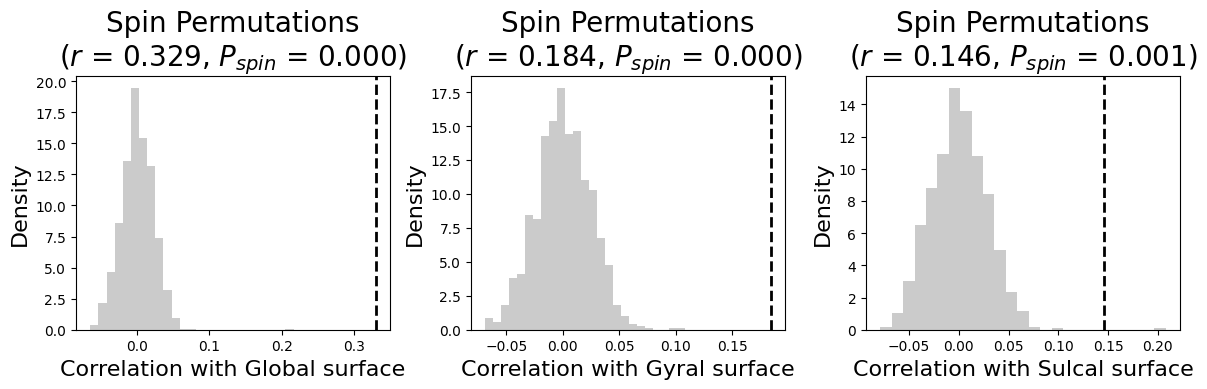

In [9]:
plot_spin_permutations(sub_id="03", qmri="T1map", cor_feat="curv")

### Curvature ~ T1 map G1 (Subject02)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


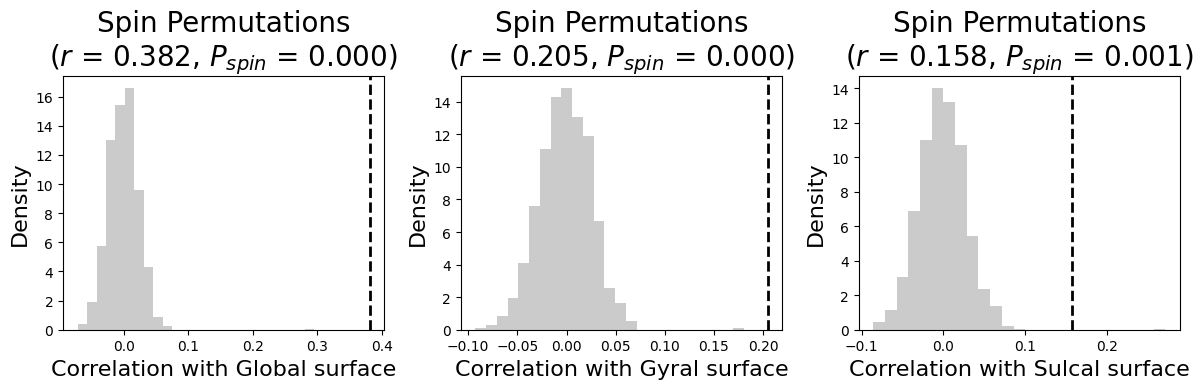

In [10]:
plot_spin_permutations(sub_id="06", qmri="T1map", cor_feat="curv")

### Curvature ~ T1 map G1 (Subject03)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


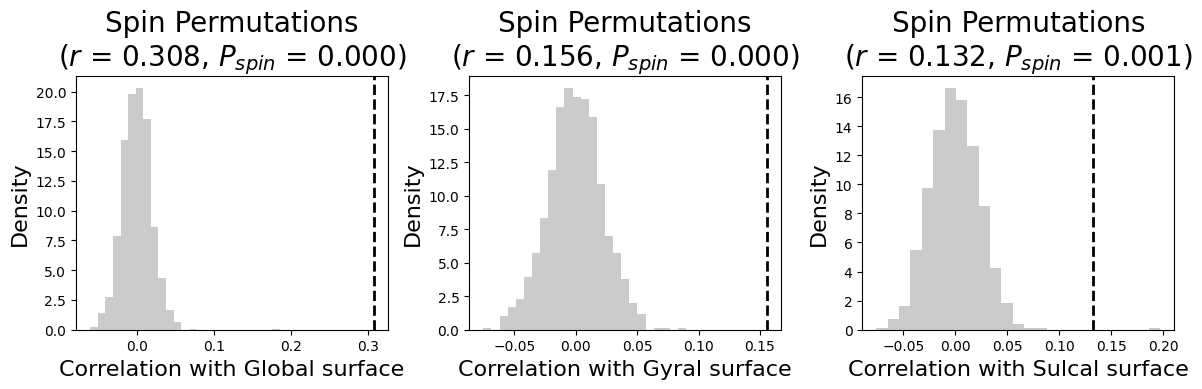

In [11]:
plot_spin_permutations(sub_id="07", qmri="T1map", cor_feat="curv")

### Curvature ~ T1 map G1 (Subject04)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


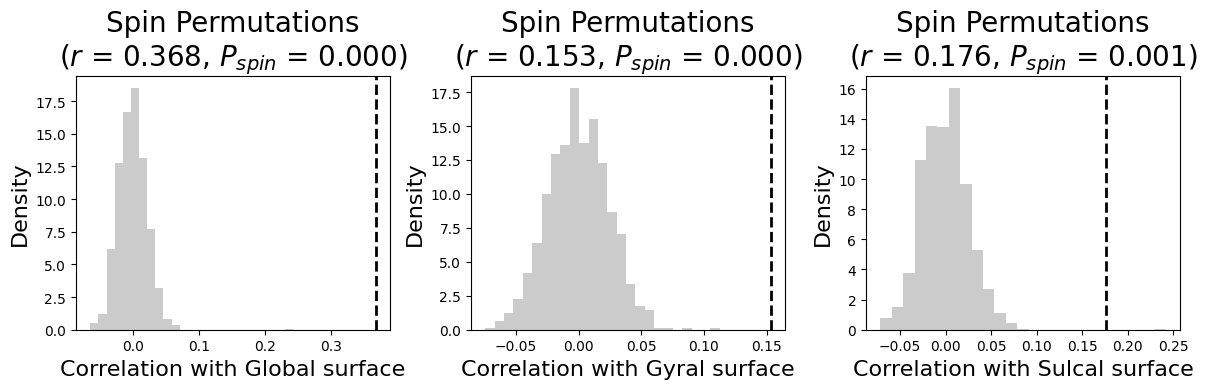

In [12]:
plot_spin_permutations(sub_id="09", qmri="T1map", cor_feat="curv")

### Curvature ~ T1 map G1 (Subject05)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


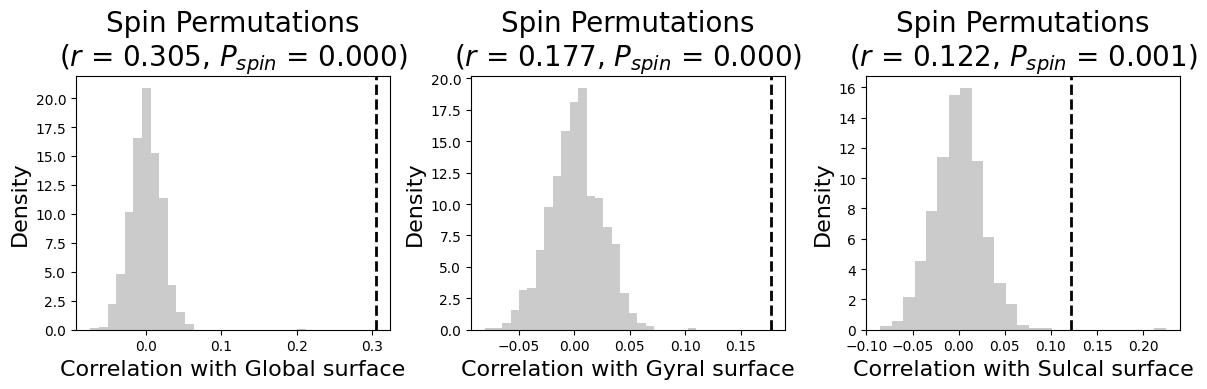

In [13]:
plot_spin_permutations(sub_id="10", qmri="T1map", cor_feat="curv")

### Curvature ~ T1 map G1 (Subject06)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


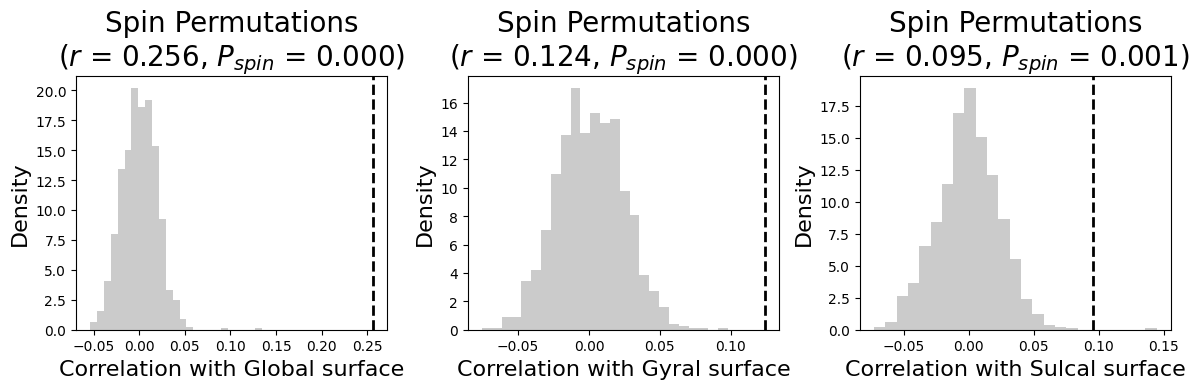

In [14]:
plot_spin_permutations(sub_id="15", qmri="T1map", cor_feat="curv")

### Curvature ~ T1 map G1 (Subject07)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


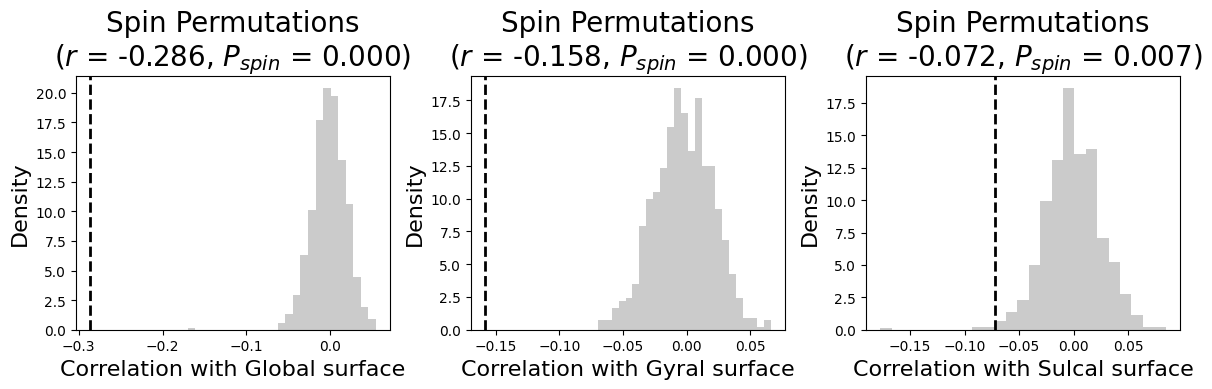

In [15]:
plot_spin_permutations(sub_id="16", qmri="T1map", cor_feat="curv")

### Curvature ~ T1 map G1 (Subject08)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


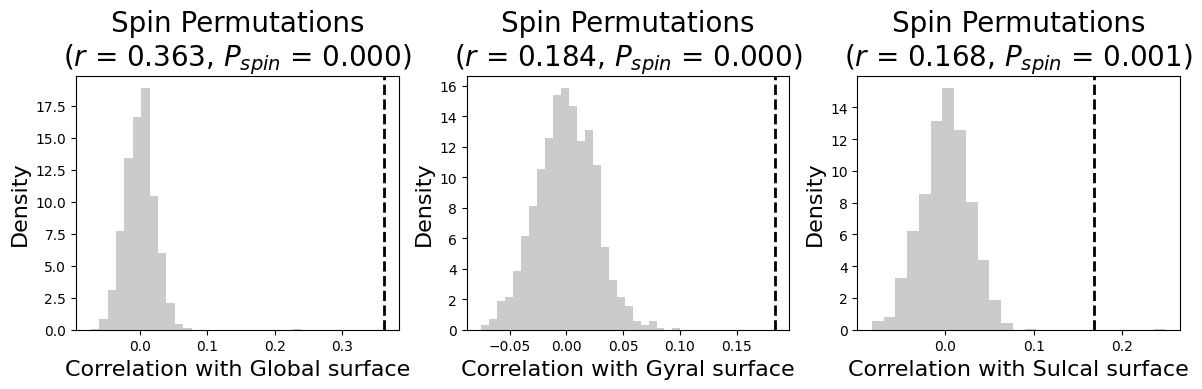

In [16]:
plot_spin_permutations(sub_id="18", qmri="T1map", cor_feat="curv")

### Curvature ~ T1 map G1 (Subject09)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


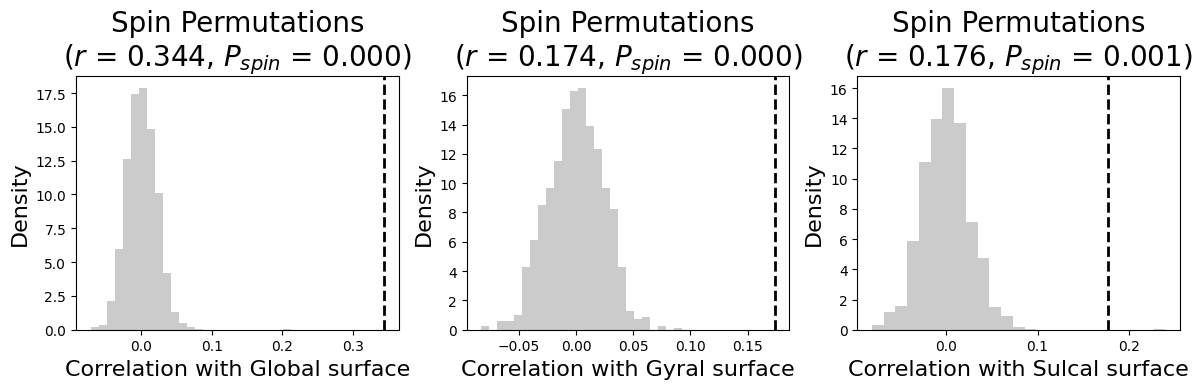

In [17]:
plot_spin_permutations(sub_id="19", qmri="T1map", cor_feat="curv")

### Curvature ~ T1 map G1 (Subject10)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


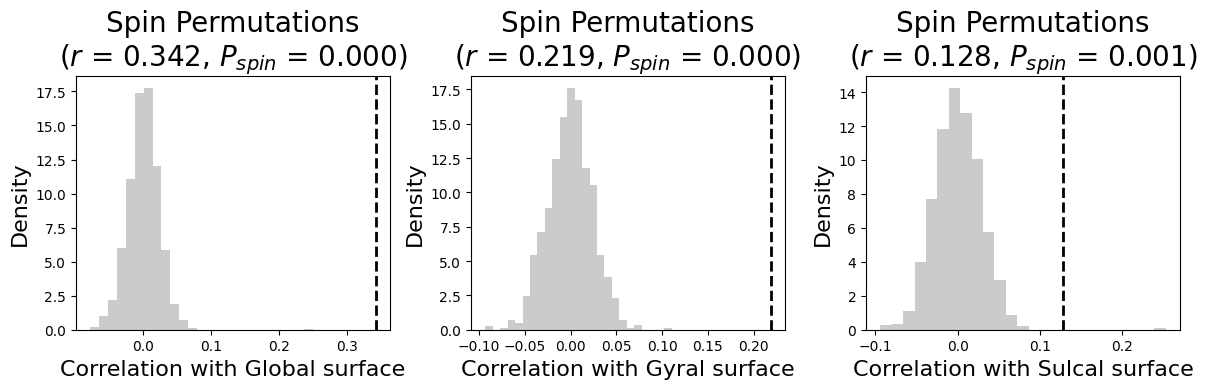

In [18]:
plot_spin_permutations(sub_id="22", qmri="T1map", cor_feat="curv")

## Curvature ~ MTsat G1
We have 10 PNC subjects. (PNC003, PNC006, PNC007, PNC009, PNC010, PNC015, PNC016, PNC018, PNC019, PNC022)

### Curvature ~ MTsat G1 (Subject01)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


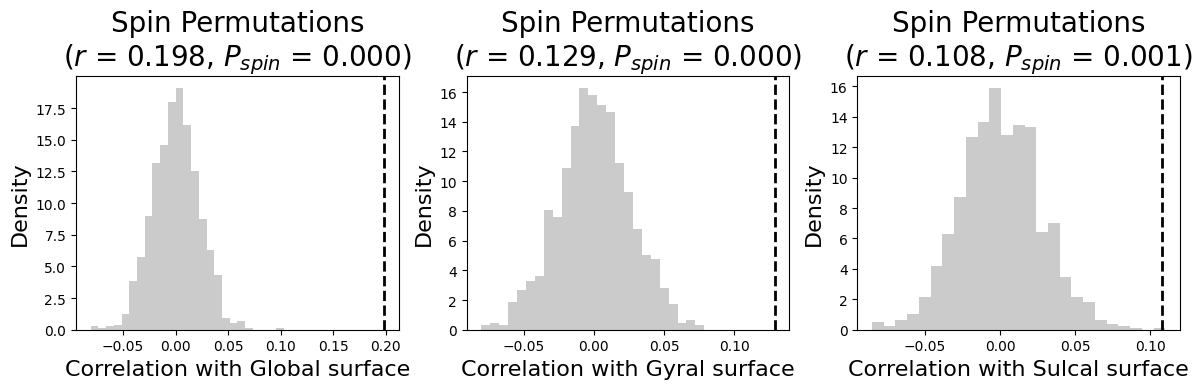

In [59]:
plot_spin_permutations(sub_id="03", qmri="MTSAT_new", cor_feat="curv")

### Curvature ~ MTsat G1 (Subject02)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


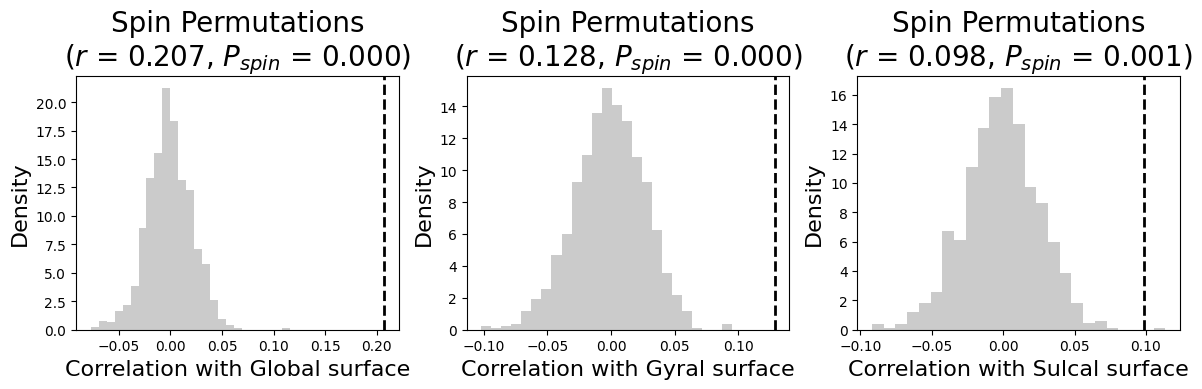

In [60]:
plot_spin_permutations(sub_id="06", qmri="MTSAT_new", cor_feat="curv")

### Curvature ~ MTsat G1 (Subject03)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


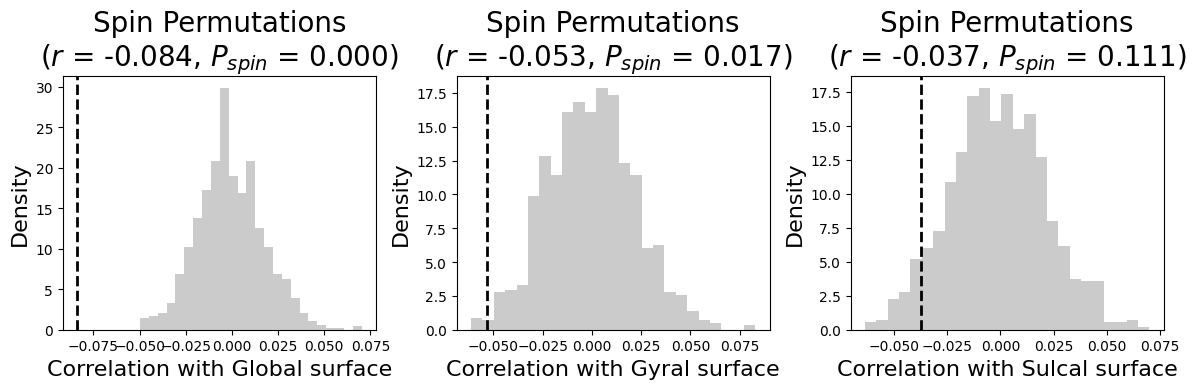

In [61]:
plot_spin_permutations(sub_id="07", qmri="MTSAT_new", cor_feat="curv")

### Curvature ~ MTsat G1 (Subject04)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


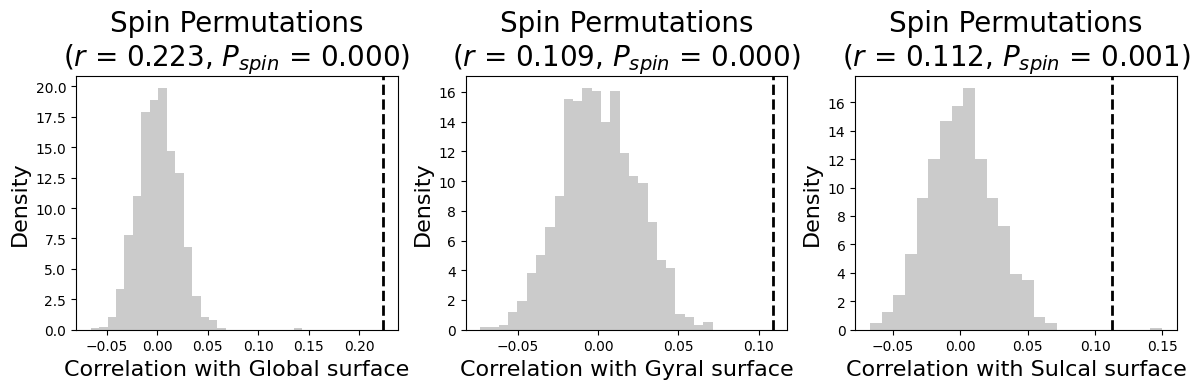

In [62]:
plot_spin_permutations(sub_id="09", qmri="MTSAT_new", cor_feat="curv")

### Curvature ~ MTsat G1 (Subject05)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


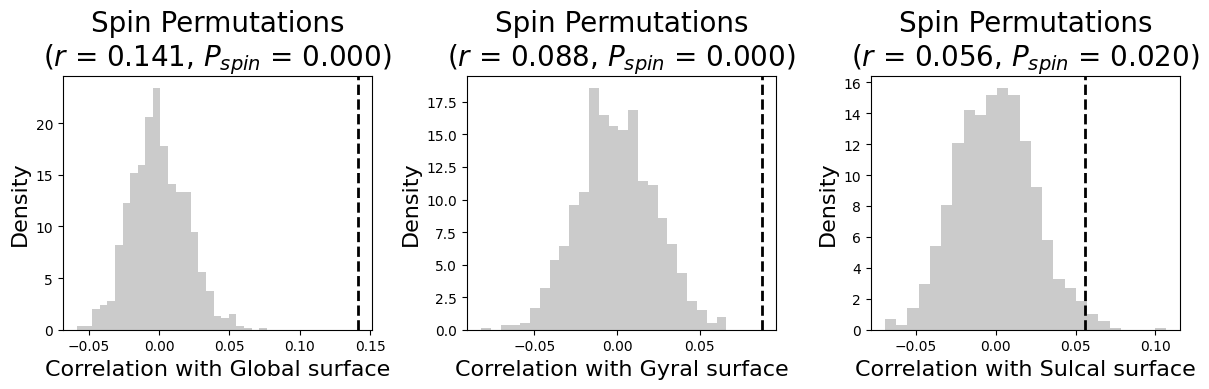

In [63]:
plot_spin_permutations(sub_id="10", qmri="MTSAT_new", cor_feat="curv")

### Curvature ~ MTsat G1 (Subject06)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


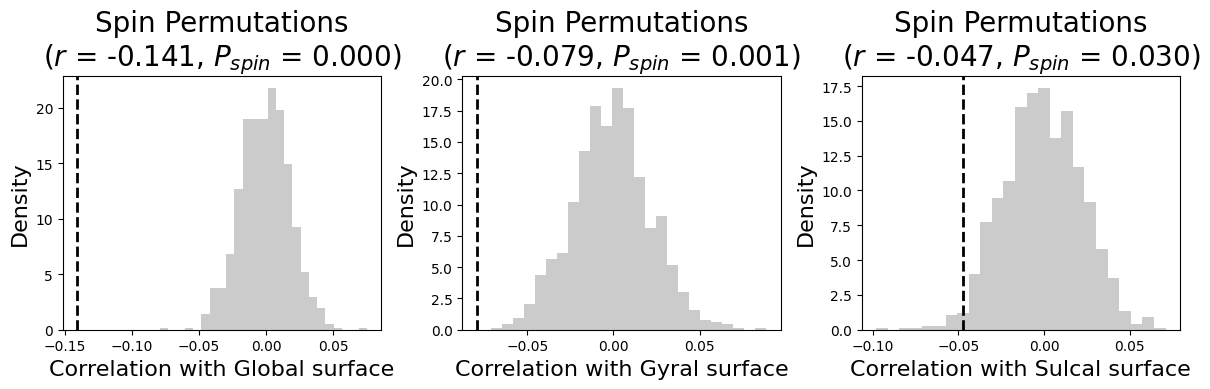

In [64]:
plot_spin_permutations(sub_id="15", qmri="MTSAT_new", cor_feat="curv")

### Curvature ~ MTsat G1 (Subject07)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


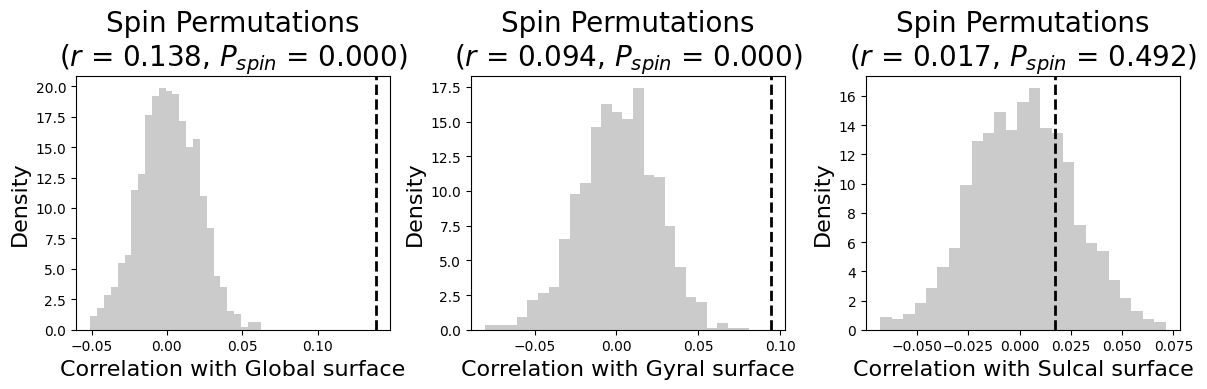

In [65]:
plot_spin_permutations(sub_id="16", qmri="MTSAT_new", cor_feat="curv")

### Curvature ~ MTsat G1 (Subject08)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


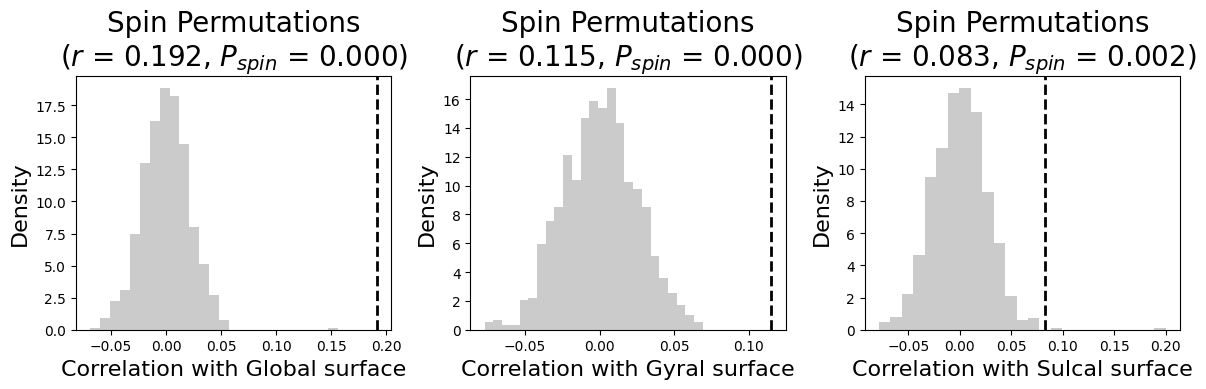

In [66]:
plot_spin_permutations(sub_id="18", qmri="MTSAT_new", cor_feat="curv")

### Curvature ~ MTsat G1 (Subject09)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


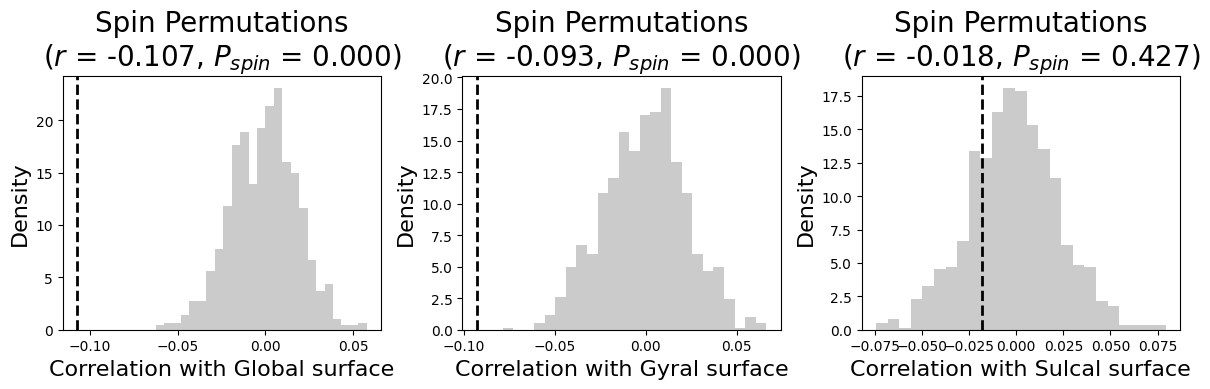

In [67]:
plot_spin_permutations(sub_id="19", qmri="MTSAT_new", cor_feat="curv")

### Curvature ~ MTsat G1 (Subject10)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


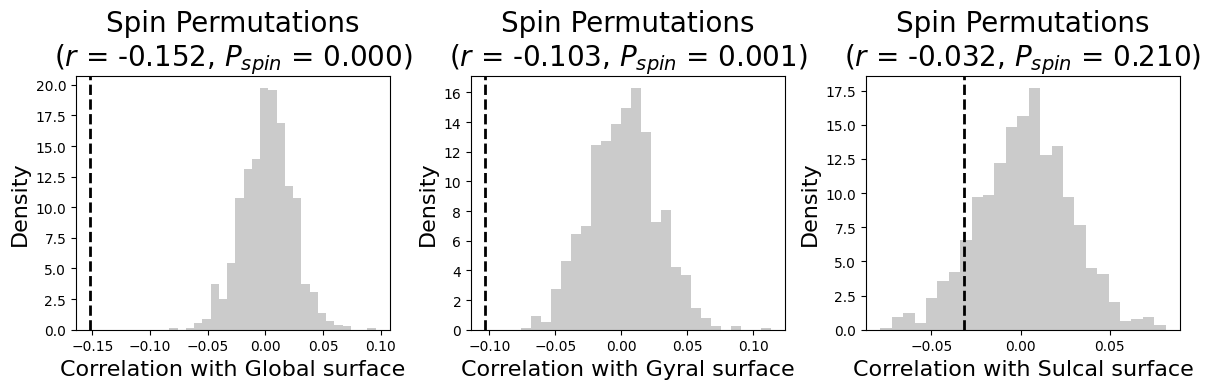

In [68]:
plot_spin_permutations(sub_id="22", qmri="MTSAT_new", cor_feat="curv")

## Cortical thickness ~ T1map G1
We have 10 PNC subjects. (PNC003, PNC006, PNC007, PNC009, PNC010, PNC015, PNC016, PNC018, PNC019, PNC022)

### Cortical thickness ~ T1map G1 (Subject01)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


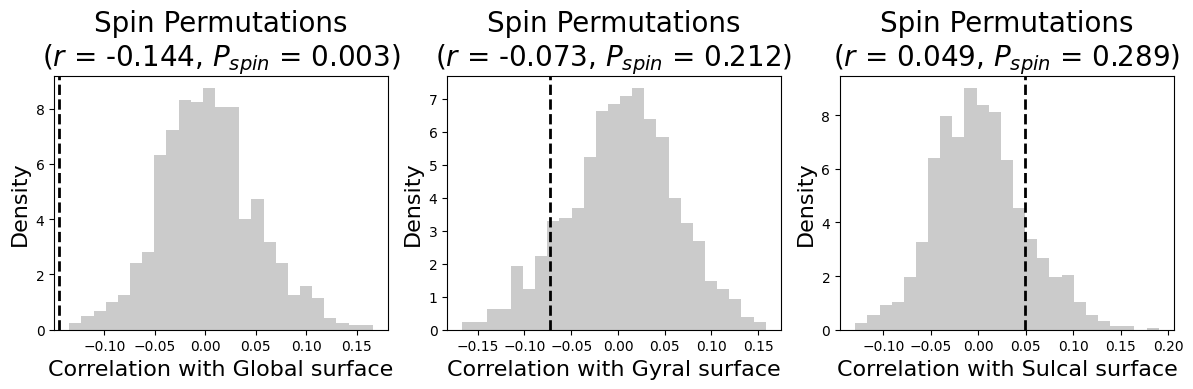

In [29]:
plot_spin_permutations(sub_id="03", qmri="T1map", cor_feat="thickness")

### Cortical thickness ~ T1map G1 (Subject02)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


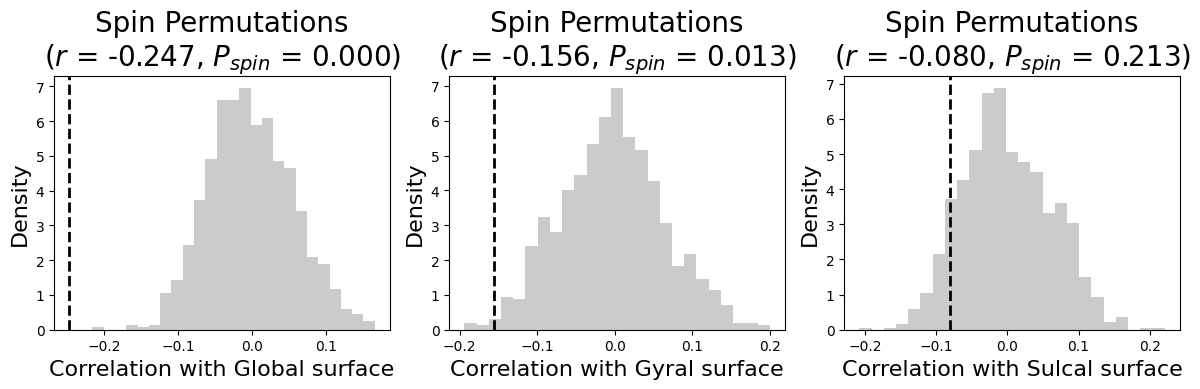

In [30]:
plot_spin_permutations(sub_id="06", qmri="T1map", cor_feat="thickness")

### Cortical thickness ~ T1map G1 (Subject03)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


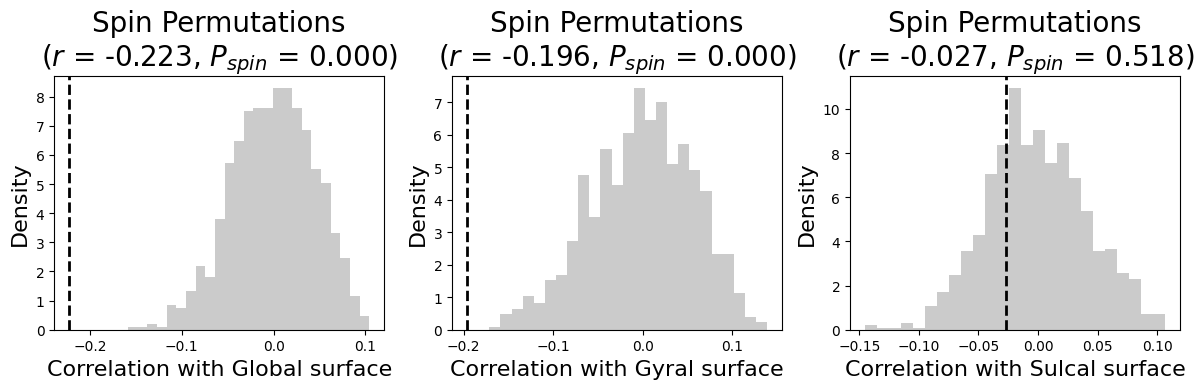

In [31]:
plot_spin_permutations(sub_id="07", qmri="T1map", cor_feat="thickness")

### Cortical thickness ~ T1map G1 (Subject04)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


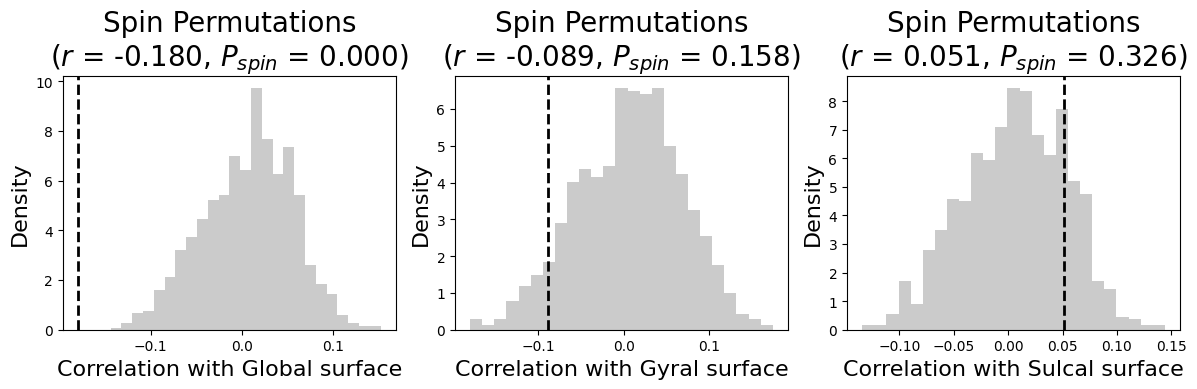

In [32]:
plot_spin_permutations(sub_id="09", qmri="T1map", cor_feat="thickness")

### Cortical thickness ~ T1map G1 (Subject05)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


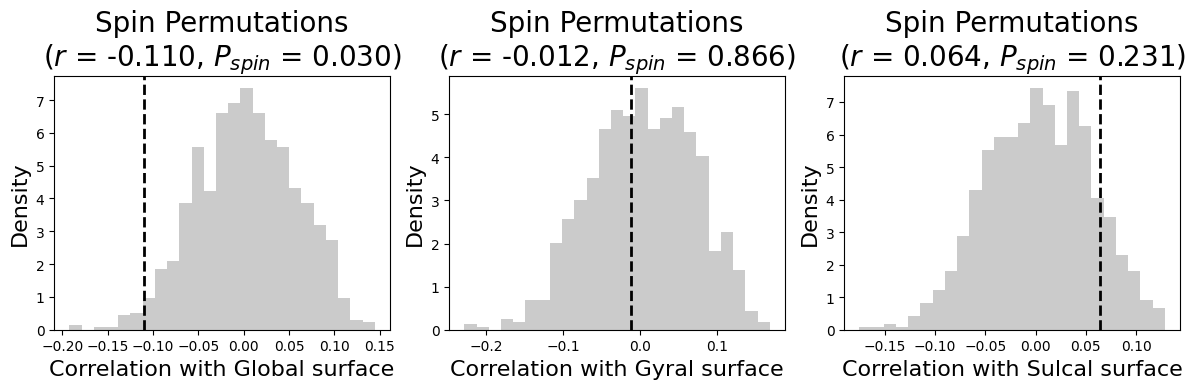

In [33]:
plot_spin_permutations(sub_id="10", qmri="T1map", cor_feat="thickness")

### Cortical thickness ~ T1map G1 (Subject06)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


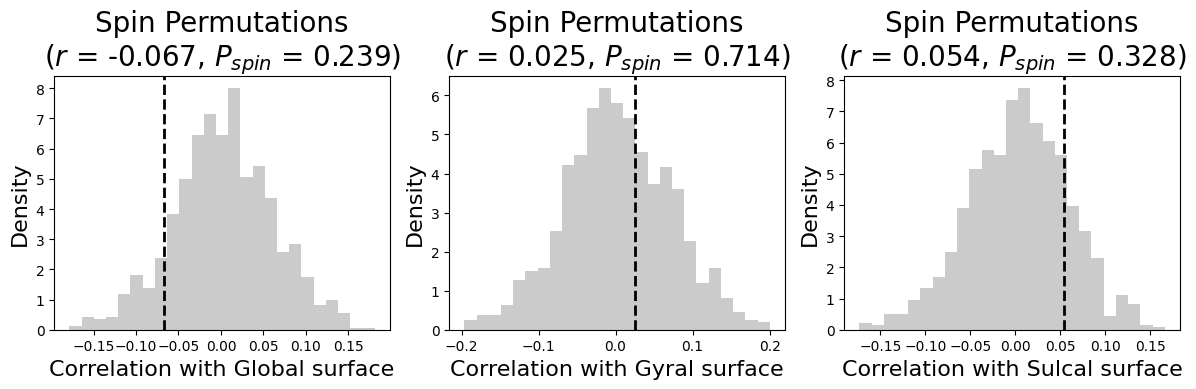

In [34]:
plot_spin_permutations(sub_id="15", qmri="T1map", cor_feat="thickness")

### Cortical thickness ~ T1map G1 (Subject07)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


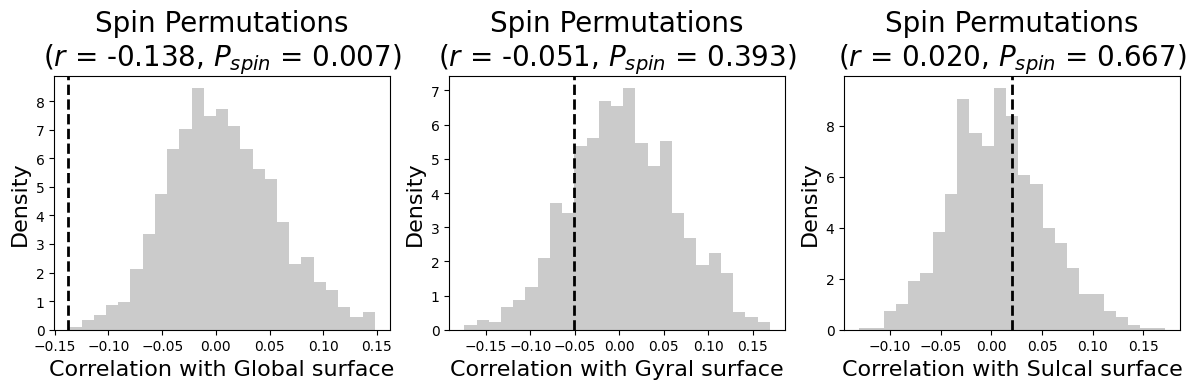

In [35]:
plot_spin_permutations(sub_id="16", qmri="T1map", cor_feat="thickness")

### Cortical thickness ~ T1map G1 (Subject08)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


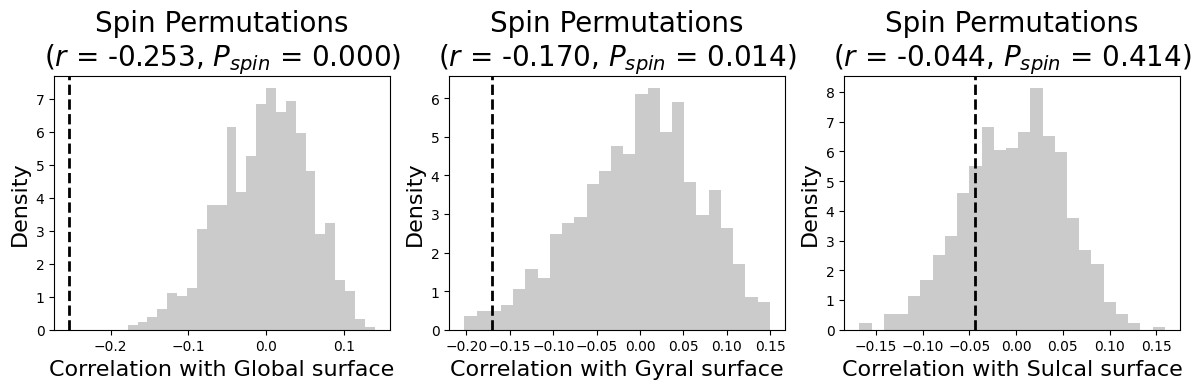

In [36]:
plot_spin_permutations(sub_id="18", qmri="T1map", cor_feat="thickness")

### Cortical thickness ~ T1map G1 (Subject09)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


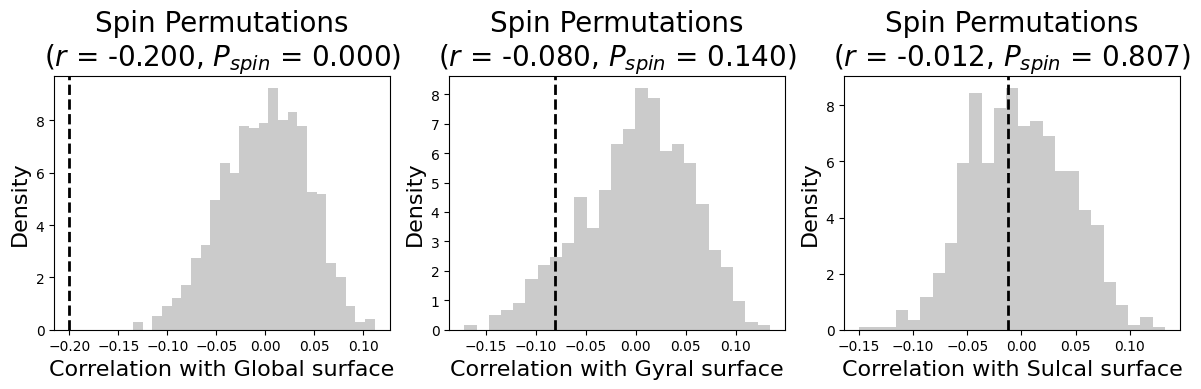

In [37]:
plot_spin_permutations(sub_id="19", qmri="T1map", cor_feat="thickness")

### Cortical thickness ~ T1map G1 (Subject10)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


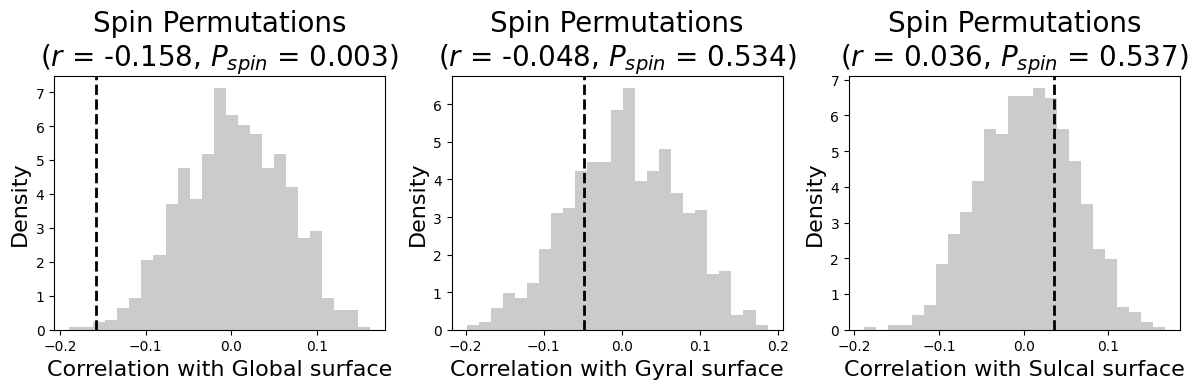

In [38]:
plot_spin_permutations(sub_id="22", qmri="T1map", cor_feat="thickness")

## Cortical thickness ~ MTsat G1
We have 10 PNC subjects. (PNC003, PNC006, PNC007, PNC009, PNC010, PNC015, PNC016, PNC018, PNC019, PNC022)

### Cortical thickness ~ MTsat G1 (Subject01)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


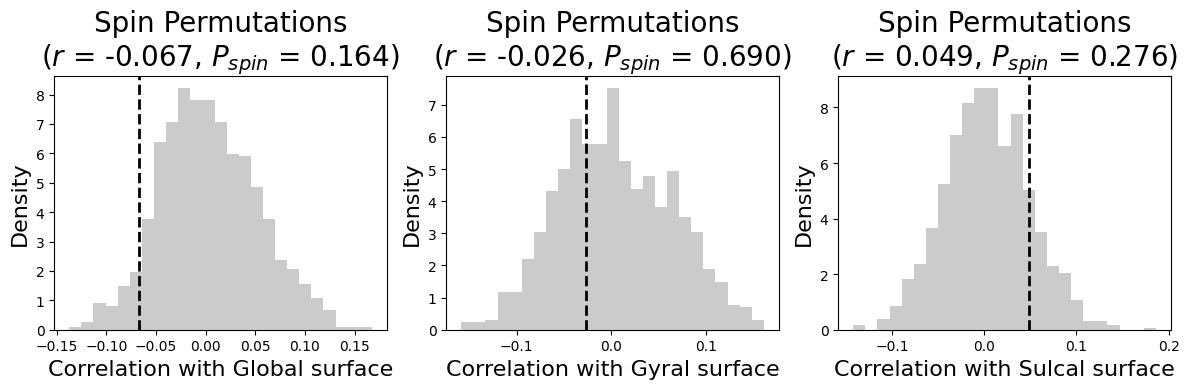

In [49]:
plot_spin_permutations(sub_id="03", qmri="MTSAT_new", cor_feat="thickness")

### Cortical thickness ~ MTsat G1 (Subject02)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


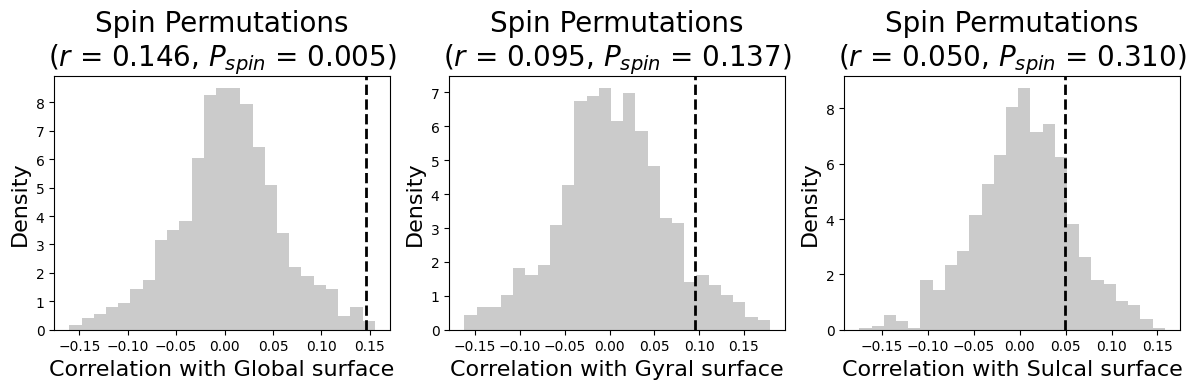

In [50]:
plot_spin_permutations(sub_id="06", qmri="MTSAT_new", cor_feat="thickness")

### Cortical thickness ~ MTsat G1 (Subject03)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


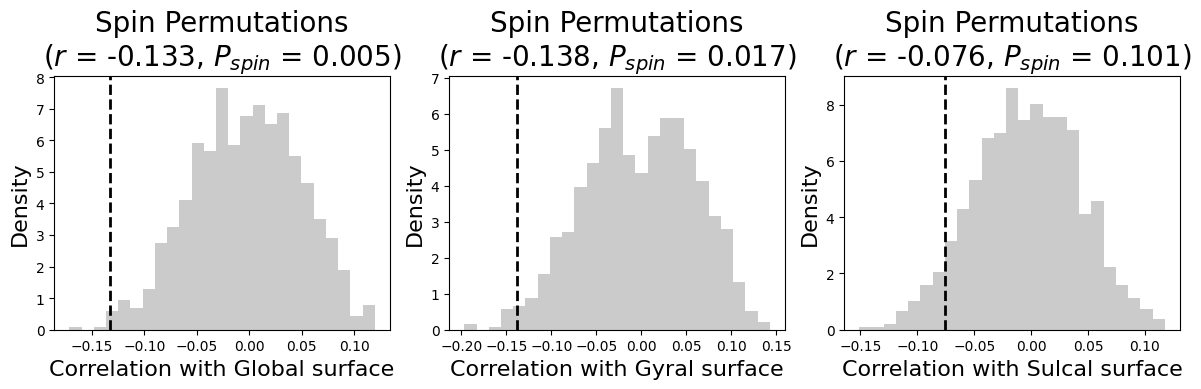

In [51]:
plot_spin_permutations(sub_id="07", qmri="MTSAT_new", cor_feat="thickness")

### Cortical thickness ~ MTsat G1 (Subject04)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


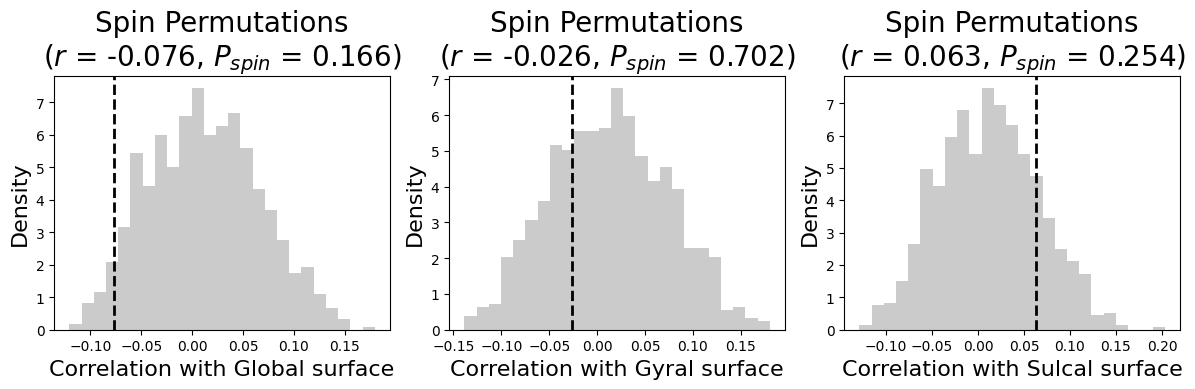

In [52]:
plot_spin_permutations(sub_id="09", qmri="MTSAT_new", cor_feat="thickness")

### Cortical thickness ~ MTsat G1 (Subject05)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


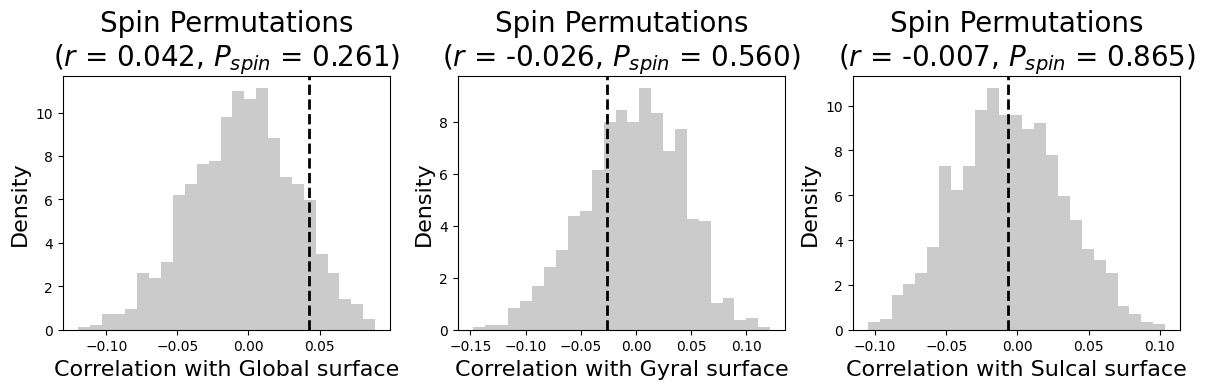

In [53]:
plot_spin_permutations(sub_id="10", qmri="MTSAT_new", cor_feat="thickness")

### Cortical thickness ~ MTsat G1 (Subject06)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


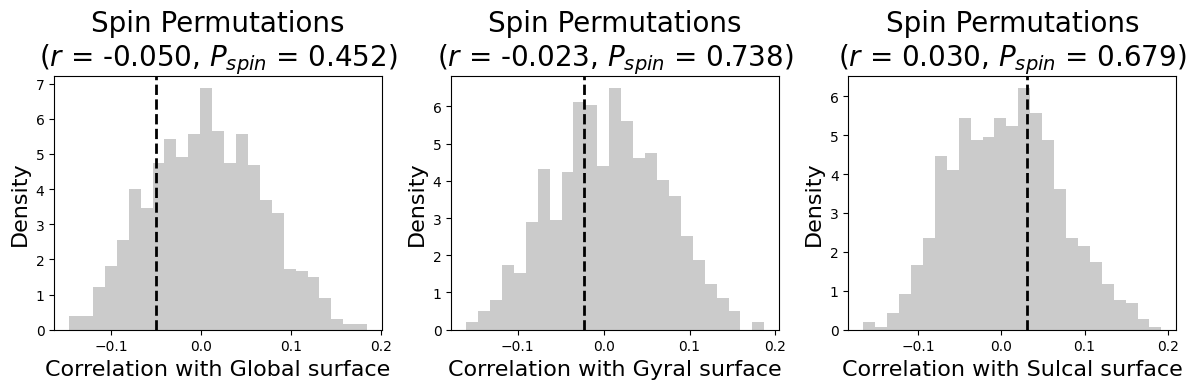

In [54]:
plot_spin_permutations(sub_id="15", qmri="MTSAT_new", cor_feat="thickness")

### Cortical thickness ~ MTsat G1 (Subject07)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


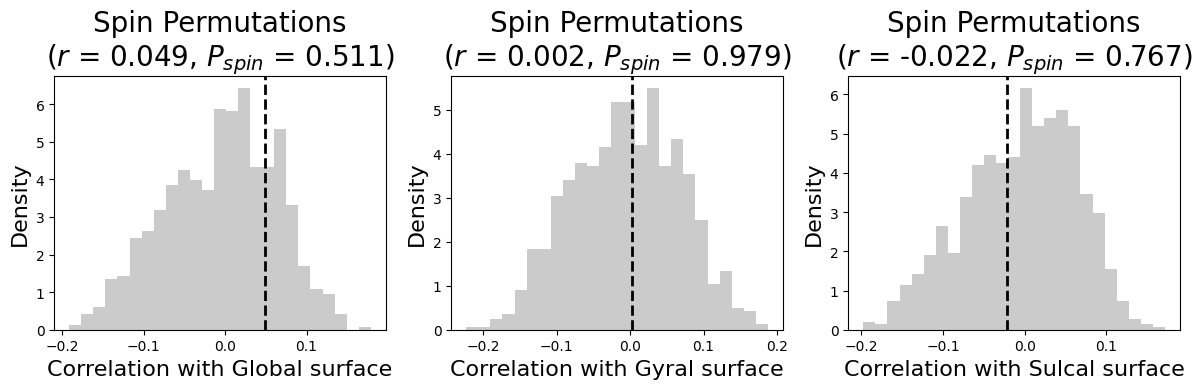

In [55]:
plot_spin_permutations(sub_id="16", qmri="MTSAT_new", cor_feat="thickness")

### Cortical thickness ~ MTsat G1 (Subject08)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


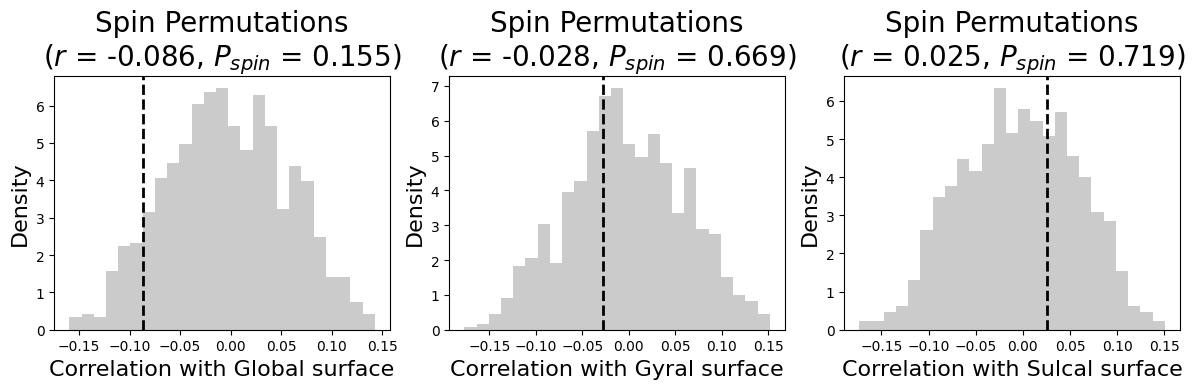

In [56]:
plot_spin_permutations(sub_id="18", qmri="MTSAT_new", cor_feat="thickness")

### Cortical thickness ~ MTsat G1 (Subject09)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


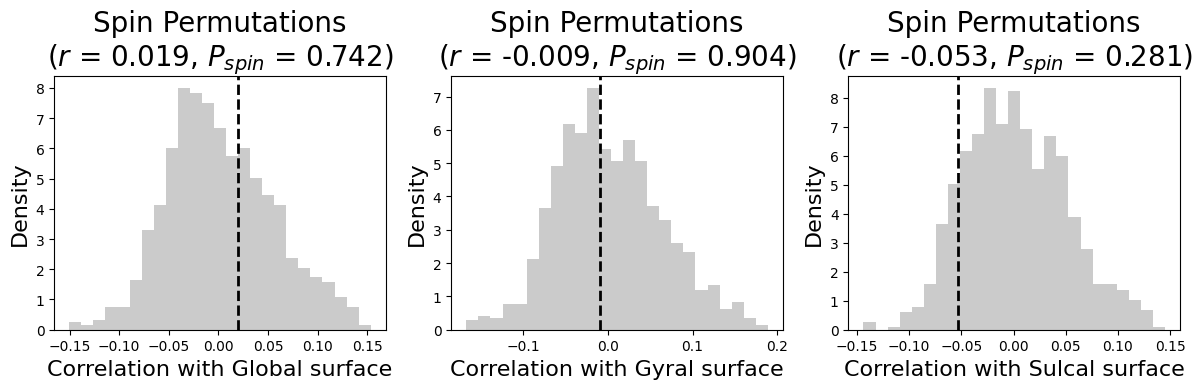

In [57]:
plot_spin_permutations(sub_id="19", qmri="MTSAT_new", cor_feat="thickness")

### Cortical thickness ~ MTsat G1 (Subject10)

/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
/tmp/ipykernel_3687984/11435069.py:22: RuntimeWarning: divide by zero encountered in log
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


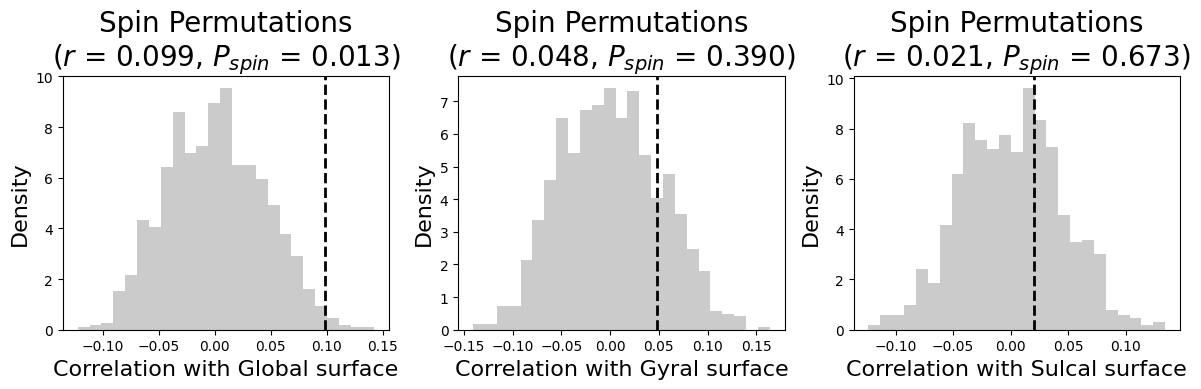

In [58]:
plot_spin_permutations(sub_id="22", qmri="MTSAT_new", cor_feat="thickness")